# DCGAN implementation on MNIST DATA
   

In [21]:
# load modules
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Conv2d
from torch.nn import BatchNorm2d
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import ConvTranspose2d
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import imageio

In [22]:
img_size=64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
to_image = transforms.ToPILImage()
trainset = datasets.MNIST(root="./mnist_data",train=True,download=True,transform=transform)
trainloader = DataLoader(trainset,batch_size=100,shuffle=True)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Defining Generator
    Input to Generator is noise of 100 dimension and the output is expected to be an image of size 28X28
    

In [24]:
class Generator(nn.Module):
    def __init__(self,n=100):
        nc = 1 # output channels is expected to of 1 dimension as channels of MNIST data generation is 1X64X64
        nf = 64
        super(Generator,self).__init__()
        self.genr = nn.Sequential(
            # 100 size initially
            ConvTranspose2d(n,nf*8,4,1,0),
            BatchNorm2d(nf*8),
            ReLU(True),
            
            # (nf*8)X 4 X 4
            ConvTranspose2d(nf*8,nf*4,4,2,1),
            BatchNorm2d(nf*4),
            ReLU(True),
            
            # (nf*4) X 8 X 8
            ConvTranspose2d(nf*4,nf*2,4,2,1),
            BatchNorm2d(nf*2),
            ReLU(True),
            
            # (nf*2) X 16 X 16
            ConvTranspose2d(nf*2,nf,4,2,1),
            BatchNorm2d(nf),
            ReLU(True),
            
            # (nf) X 32 X 32
            ConvTranspose2d(nf,nc,4,2,1),
            Tanh()
            #output size is (nc) X 64 X 64
        )
    
    def forward(self,x):
        output = self.genr(x)
        return output
Generator()

Generator(
  (genr): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

##### Defining Discriminator

    Input to Discriminator is expected to be an image of 28X28 size and the output is logit of dimension of 1

In [25]:
class Disciminator(nn.Module):
    def __init__(self,d=64):
        super(Disciminator,self).__init__()
        self.discr = nn.Sequential(
            # 1X64 X 64 size initially
            Conv2d(1,d,4,2,1),
            BatchNorm2d(d),
            ReLU(True),
            
            # state is in dX32X32
            Conv2d(d,2*d,4,2,1),
            BatchNorm2d(2*d),
            ReLU(True),
            
            #state is in dX16X16
            Conv2d(2*d,4*d,4,2,1),
            BatchNorm2d(4*d),
            ReLU(True),
            
            #state is in dX8X8
            Conv2d(4*d,8*d,4,2,1),
            BatchNorm2d(8*d),
            ReLU(True),
            
            #state is in dX4X4
            Conv2d(8*d,1,4,1,0),
            Sigmoid()
        )
    
    def forward(self,x):
        output = self.discr(x)
        return output.view(-1)
Disciminator()

Disciminator(
  (discr): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [26]:
generator = Generator()
discriminator = Disciminator()
generator.to(device)
discriminator.to(device)
g_optim = optim.Adam(generator.parameters(),lr=0.00002)
d_optim = optim.Adam(discriminator.parameters(),lr=0.00002)
g_losses=[]
d_losses=[]
images=[]
criterion = nn.BCELoss()

def noise(batch_size,nc=100):
    return Variable(torch.randn(batch_size,nc,1,1)).to(device)
    
def make_ones(batch_size):
    label = Variable(torch.full((batch_size,), 1)).to(device)
    return label

def make_zeros(batch_size):
    label = Variable(torch.full((batch_size,), 0)).to(device)
    return label
    

In [27]:
def train_discriminator(optimizer,real_data,fake_data):
    batch_size = real_data.size(0)
    
    real_predictions = discriminator(real_data)
    real_loss = criterion(real_predictions,make_ones(batch_size))
    real_loss.backward()
    
    fake_predictions = discriminator(fake_data)
    fake_loss = criterion(fake_predictions,make_zeros(batch_size))
    fake_loss.backward()
    
    optimizer.step()
    
    return real_loss + fake_loss

def train_generator(optimizer,fake_data):
    batch_size = fake_data.size(0)
    
    fake_predictions = discriminator(fake_data)
    fake_loss = criterion(fake_predictions,make_ones(batch_size))
    fake_loss.backward()
    
    optimizer.step()

    return fake_loss

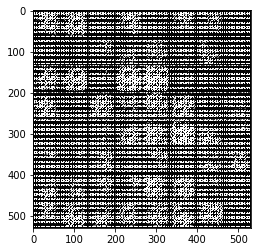

Epoch 0: g_loss is 1.302172 and d_loss is 1.371296 


In [ ]:
num_epochs = 100
test_noise = noise(64)
z=100 # input radom vector size
for epoch in range(num_epochs):
    d_error=0.0
    g_error=0.0
    for i,data in enumerate(trainloader):
        inputs,_ = data
        real_data = inputs.to(device)
        batch_size = inputs.size(0)
        
        #maximize log(D(X)) + log(1-D(G(Z)))
        
        fake_data = generator(noise(batch_size,z)).detach()
        d_error += train_discriminator(d_optim,real_data,fake_data)
        
        # maximize log(D(G(Z)))
        fake_data = generator(noise(batch_size,z))
        g_error += train_generator(g_optim,fake_data)
        
    
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    plt.imshow(np.array(to_image(img)))
    plt.show()
    images.append(img)
    print("Epoch {}: g_loss is {:.6f} and d_loss is {:.6f} ".format(epoch,g_error/i,d_error/i))

print("Finished Training")
torch.save(generator.state_dict(),"dcgan_mnist.pt")

In [ ]:
plt.plot(g_losses,label="generator loss")
plt.plot(d_losses,label="discriminator loss")
plt.legend()
plt.show()

In [ ]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

In [ ]:
!pwd